## In this notebook we are going to develop a classification task for the dataset CIFAR 10 using convolutional neural networks.

In [1]:
# Importing section

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [21]:
num_workers = 0
batch_size = 20
validation_size = 0.2

transform = transforms.Compose([transforms.RandomRotation(10), transforms.RandomHorizontalFlip(), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train  = False, download = True, transform = transform)

lenght = len(train_data)
indices = list(range(lenght))
np.random.shuffle(indices)
splitting_value = int(lenght*validation_size)
valid = indices[:splitting_value]
train = indices[splitting_value:]

valid_sampler = SubsetRandomSampler(valid)
train_sampler = SubsetRandomSampler(train)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Definition of the net

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(64*4*4, 500)
        self.linear2 = nn.Linear(500, 10)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, state):
        state = self.pool(F.relu(self.conv1(state)))
        state = self.pool(F.relu(self.conv2(state)))
        state = self.pool(F.relu(self.conv3(state)))
        
        state = state.view(-1, 64*4*4)
        state = self.dropout(state)
        state = F.relu(self.linear1(state))
        state = self.dropout(state)
        output = self.linear2(state)
        return output

## Instatiation of the net, criterion and optimizer

In [33]:
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

## Training

In [35]:
epochs = 30

min_valid_loss = np.Inf

for epoch in range(1, epochs + 1):
    
    train_loss = 0
    valid_loss = 0
    
    net.train()
    
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        
        output = net(data)
        
        optimizer.zero_grad()
        loss = criterion(output, labels)
               
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size()[0]
        
    net.eval()
    
    for data, labels in valid_loader:
        data = data.to(device)
        labels = labels.to(device)
        
        output = net(data)
        
        loss = criterion(output, labels)
        valid_loss += loss.item()*data.size()[0]
        
    valid_loss = valid_loss/(len(valid_loader.dataset))
    train_loss = train_loss/(len(train_loader.dataset))
    
    if valid_loss<min_valid_loss:
        min_valid_loss = valid_loss
        print('---------')
        print('The new minimum valid loss is ', min_valid_loss)
        torch.save(net.state_dict(), 'best_CIFAR_10.pt')
        
    print('\n The train loss at epoch %.2d is %.6f. '%(epoch, train_loss))
    print('\n The validation loss at epoch %.2d is %.6f '%(epoch, valid_loss))

---------
The new minimum valid loss is  0.238337792301178

 The train loss at epoch 01 is 1.032485. 

 The validation loss at epoch 01 is 0.238338 
---------
The new minimum valid loss is  0.2258710458278656

 The train loss at epoch 02 is 0.979755. 

 The validation loss at epoch 02 is 0.225871 
---------
The new minimum valid loss is  0.21505691349506378

 The train loss at epoch 03 is 0.939421. 

 The validation loss at epoch 03 is 0.215057 
---------
The new minimum valid loss is  0.21045541611909865

 The train loss at epoch 04 is 0.895766. 

 The validation loss at epoch 04 is 0.210455 
---------
The new minimum valid loss is  0.2032794002175331

 The train loss at epoch 05 is 0.865462. 

 The validation loss at epoch 05 is 0.203279 
---------
The new minimum valid loss is  0.197775192797184

 The train loss at epoch 06 is 0.835102. 

 The validation loss at epoch 06 is 0.197775 
---------
The new minimum valid loss is  0.19125760180950166

 The train loss at epoch 07 is 0.81070

## Loading the best result

In [42]:
net.load_state_dict(torch.load('best_CIFAR_10.pt'))

<All keys matched successfully>

## Testing

In [44]:
test_loss = 0
classes_correct = list(0. for i in range(10))
classes_tot = list(0. for i in range(10))

for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)
    
    output = net(data)
    loss = criterion(output, labels)
    
    test_loss += loss.item()*data.size()[0]
    
    prediction = torch.max(output, 1)[1]
    prediction = prediction.eq(labels.data.view_as(prediction)).data.cpu().numpy()
    
    for i in range(10):
        classes_tot[labels[i]] += 1
        classes_correct[labels[i]] += prediction[i]
        
print('\n Total accuracy is %.3f\n'% (np.sum(classes_correct)/np.sum(classes_tot)))

for i in range(10):
    print('The accuracy for class {} is {:.3f}'.format(classes[i], np.sum(classes_correct[i])/np.sum(classes_tot[i])))
    
      


 Total accuracy is 0.759

The accuracy for class airplane is 0.818
The accuracy for class automobile is 0.916
The accuracy for class bird is 0.659
The accuracy for class cat is 0.569
The accuracy for class deer is 0.749
The accuracy for class dog is 0.606
The accuracy for class frog is 0.814
The accuracy for class horse is 0.804
The accuracy for class ship is 0.879
The accuracy for class truck is 0.774


## Plotting pics for mistakes

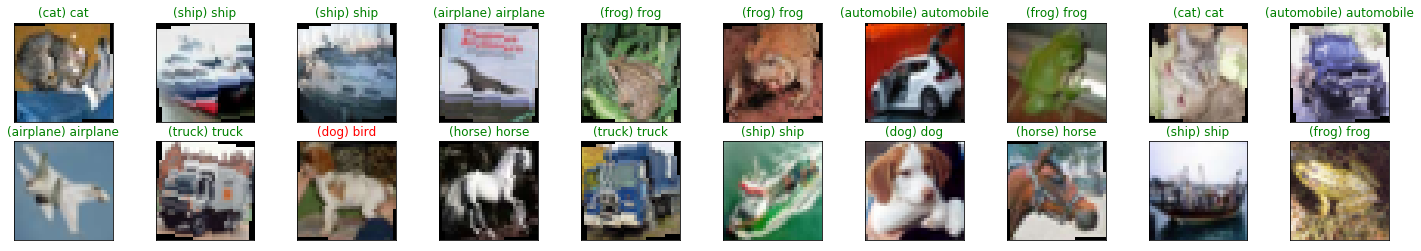

In [72]:
iterator = iter(test_loader)
data, labels = next(iterator)
data = data.to(device)
labels = labels.to(device)

output = net(data)

prediction = torch.max(output, 1)[1]
predict = prediction.eq(labels.view_as(prediction)).data.cpu().numpy()

figure = plt.figure(figsize = (25, 4))

for i in range(batch_size):
    ax = figure.add_subplot(2, 10, i+1, xticks = [], yticks = [])
    img = data[i].data.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img/2 + 0.5
    ax.imshow(img)
    ax.set_title('({}) {}'.format(classes[labels[i]], classes[prediction[i]]), color = ('green' if predict[i] == True else 'red' ))